I have used the following methods.


* I used a pretrained <b>Faster R-CNN with ResNet-50 Feature Pyramid Network</b> from detectron2 [1,2],
* I have modified the official notebook [3],


## My Another Projects
* [Mammals Classification w/Ensemble Deep Learning](https://www.kaggle.com/code/banddaniel/mammals-classification-w-ensemble-deep-learning)
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Plate Detection w/detectron2 (mAP@75: 89.19)](https://www.kaggle.com/code/banddaniel/plate-detection-w-detectron2-map-75-89-19)


## References
1. Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1506.01497
2. https://detectron2.readthedocs.io/en/latest/
3. https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [1]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

In [2]:
# Importing dependencies

import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 10
THRESHOLD = 0.25

detectron2 version: 0.6


In [3]:
# Creating coco instances

from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for d in ["train", "valid", "test"]:
    register_coco_instances(f"airplane_ship_vehicle_{d}", {},
                            f"../input/tiny-object-detection/{d}/_annotations.coco.json",
                            f"../input/tiny-object-detection/{d}")

In [4]:
# Examples from the training dataset

import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("airplane_ship_vehicle_train")
train_dataset_dicts = DatasetCatalog.get("airplane_ship_vehicle_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

[11/22 16:21:01 d2.data.datasets.coco]: Loaded 2162 images in COCO format from ../input/tiny-object-detection/train/_annotations.coco.json


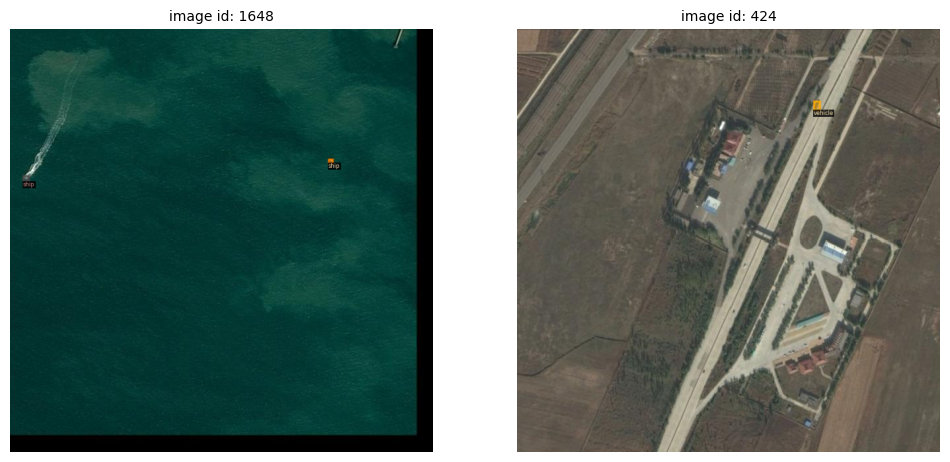

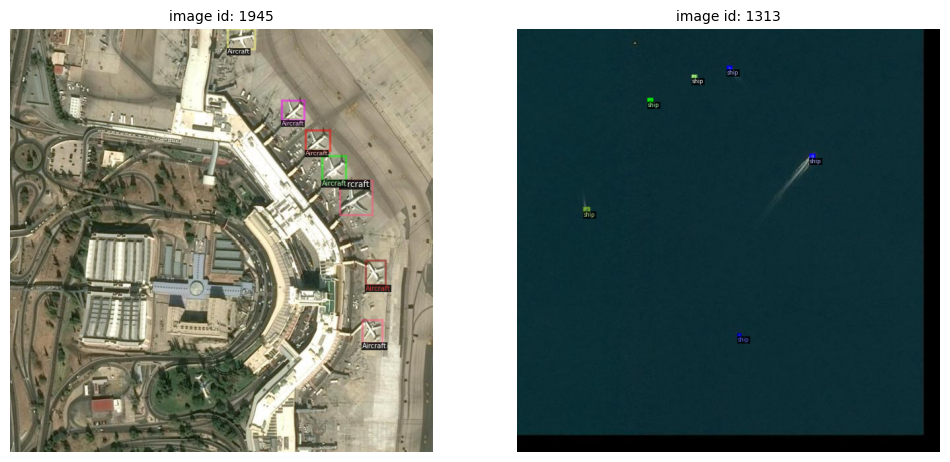

In [5]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 5 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 315 , image_scale = 1)

In [6]:
from detectron2.engine import DefaultTrainer

EPOCHS = 8500
NUM_CLASSES = 3 
BASE_LR = 0.001


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("airplane_ship_vehicle_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/22 16:21:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_b275ba.pkl: 167MB [00:05, 28.5MB/s]                           


[11/22 16:21:13 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/22 16:21:27 d2.utils.events]:  eta: 0:30:22  iter: 19  total_loss: 2.187  loss_cls: 1.356  loss_box_reg: 0.1696  loss_rpn_cls: 0.4682  loss_rpn_loc: 0.124    time: 0.2089  last_time: 0.1912  data_time: 0.0126  last_data_time: 0.0052   lr: 1.9981e-05  max_mem: 1741M


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[11/22 16:21:44 d2.utils.events]:  eta: 0:27:56  iter: 39  total_loss: 1.614  loss_cls: 0.9937  loss_box_reg: 0.1091  loss_rpn_cls: 0.2122  loss_rpn_loc: 0.1206    time: 0.2482  last_time: 0.1879  data_time: 0.0056  last_data_time: 0.0057   lr: 3.9961e-05  max_mem: 1741M
[11/22 16:21:48 d2.utils.events]:  eta: 0:27:31  iter: 59  total_loss: 1.115  loss_cls: 0.5734  loss_box_reg: 0.1522  loss_rpn_cls: 0.1833  loss_rpn_loc: 0.1331    time: 0.2279  last_time: 0.1666  data_time: 0.0056  last_data_time: 0.0053   lr: 5.9941e-05  max_mem: 1741M
[11/22 16:21:52 d2.utils.events]:  eta: 0:27:17  iter: 79  total_loss: 0.8404  loss_cls: 0.2697  loss_box_reg: 0.1459  loss_rpn_cls: 0.2071  loss_rpn_loc: 0.1396    time: 0.2194  last_time: 0.1852  data_time: 0.0054  last_data_time: 0.0061   lr: 7.9921e-05  max_mem: 1741M
[11/22 16:21:56 d2.utils.events]:  eta: 0:27:12  iter: 99  total_loss: 0.8701  loss_cls: 0.2581  loss_box_reg: 0.1998  loss_rpn_cls: 0.1647  loss_rpn_loc: 0.166    time: 0.2142  last_

In [7]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[11/22 16:49:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


# <span style="color:#e74c3c;"> Validation </span> Results

In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("airplane_ship_vehicle_valid", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "airplane_ship_vehicle_valid")
inference_on_dataset(trainer.model, test_loader, evaluator)

[11/22 16:49:13 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[11/22 16:49:14 d2.data.datasets.coco]: Loaded 622 images in COCO format from ../input/tiny-object-detection/valid/_annotations.coco.json
[11/22 16:49:14 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  Aircraft  | 0            |    ship    | 1227         |  vehicle   | 38847        |
|            |              |            |              |            |              |
|   total    | 40074        |            |              |            |              |
[11/22 16:49:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/22 16:49:14 d2.data.common]: Serializing the dataset u

OrderedDict([('bbox',
              {'AP': 4.8223323290348095,
               'AP50': 14.615743746153687,
               'AP75': 1.8185718269999702,
               'APs': 4.8965023298997625,
               'APm': 2.9677260087570887,
               'APl': nan,
               'AP-Aircraft': nan,
               'AP-ship': 5.336650485403815,
               'AP-vehicle': 4.308014172665801})])

# <span style="color:#e74c3c;"> Test </span> Results

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("airplane_ship_vehicle_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "airplane_ship_vehicle_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[11/22 16:51:38 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[11/22 16:51:38 d2.data.datasets.coco]: Loaded 311 images in COCO format from ../input/tiny-object-detection/test/_annotations.coco.json
[11/22 16:51:38 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  Aircraft  | 0            |    ship    | 656          |  vehicle   | 958          |
|            |              |            |              |            |              |
|   total    | 1614         |            |              |            |              |
[11/22 16:51:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/22 16:51:38 d2.data.common]: Serializing the dataset us

OrderedDict([('bbox',
              {'AP': 10.818314837003795,
               'AP50': 32.0835427696508,
               'AP75': 4.543636452583225,
               'APs': 10.093087527493125,
               'APm': 44.3215034063533,
               'APl': nan,
               'AP-Aircraft': nan,
               'AP-ship': 15.630068376939038,
               'AP-vehicle': 6.006561297068549})])

# <span style="color:#e74c3c;"> Test </span> Predictions

In [10]:
my_dataset_test_metadata = MetadataCatalog.get("airplane_ship_vehicle_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("airplane_ship_vehicle_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]
    
    fig, axs = plt.subplots(3,2, figsize = (10,20), dpi = 200)
    
    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        
        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

[11/22 16:51:58 d2.data.datasets.coco]: Loaded 311 images in COCO format from ../input/tiny-object-detection/test/_annotations.coco.json


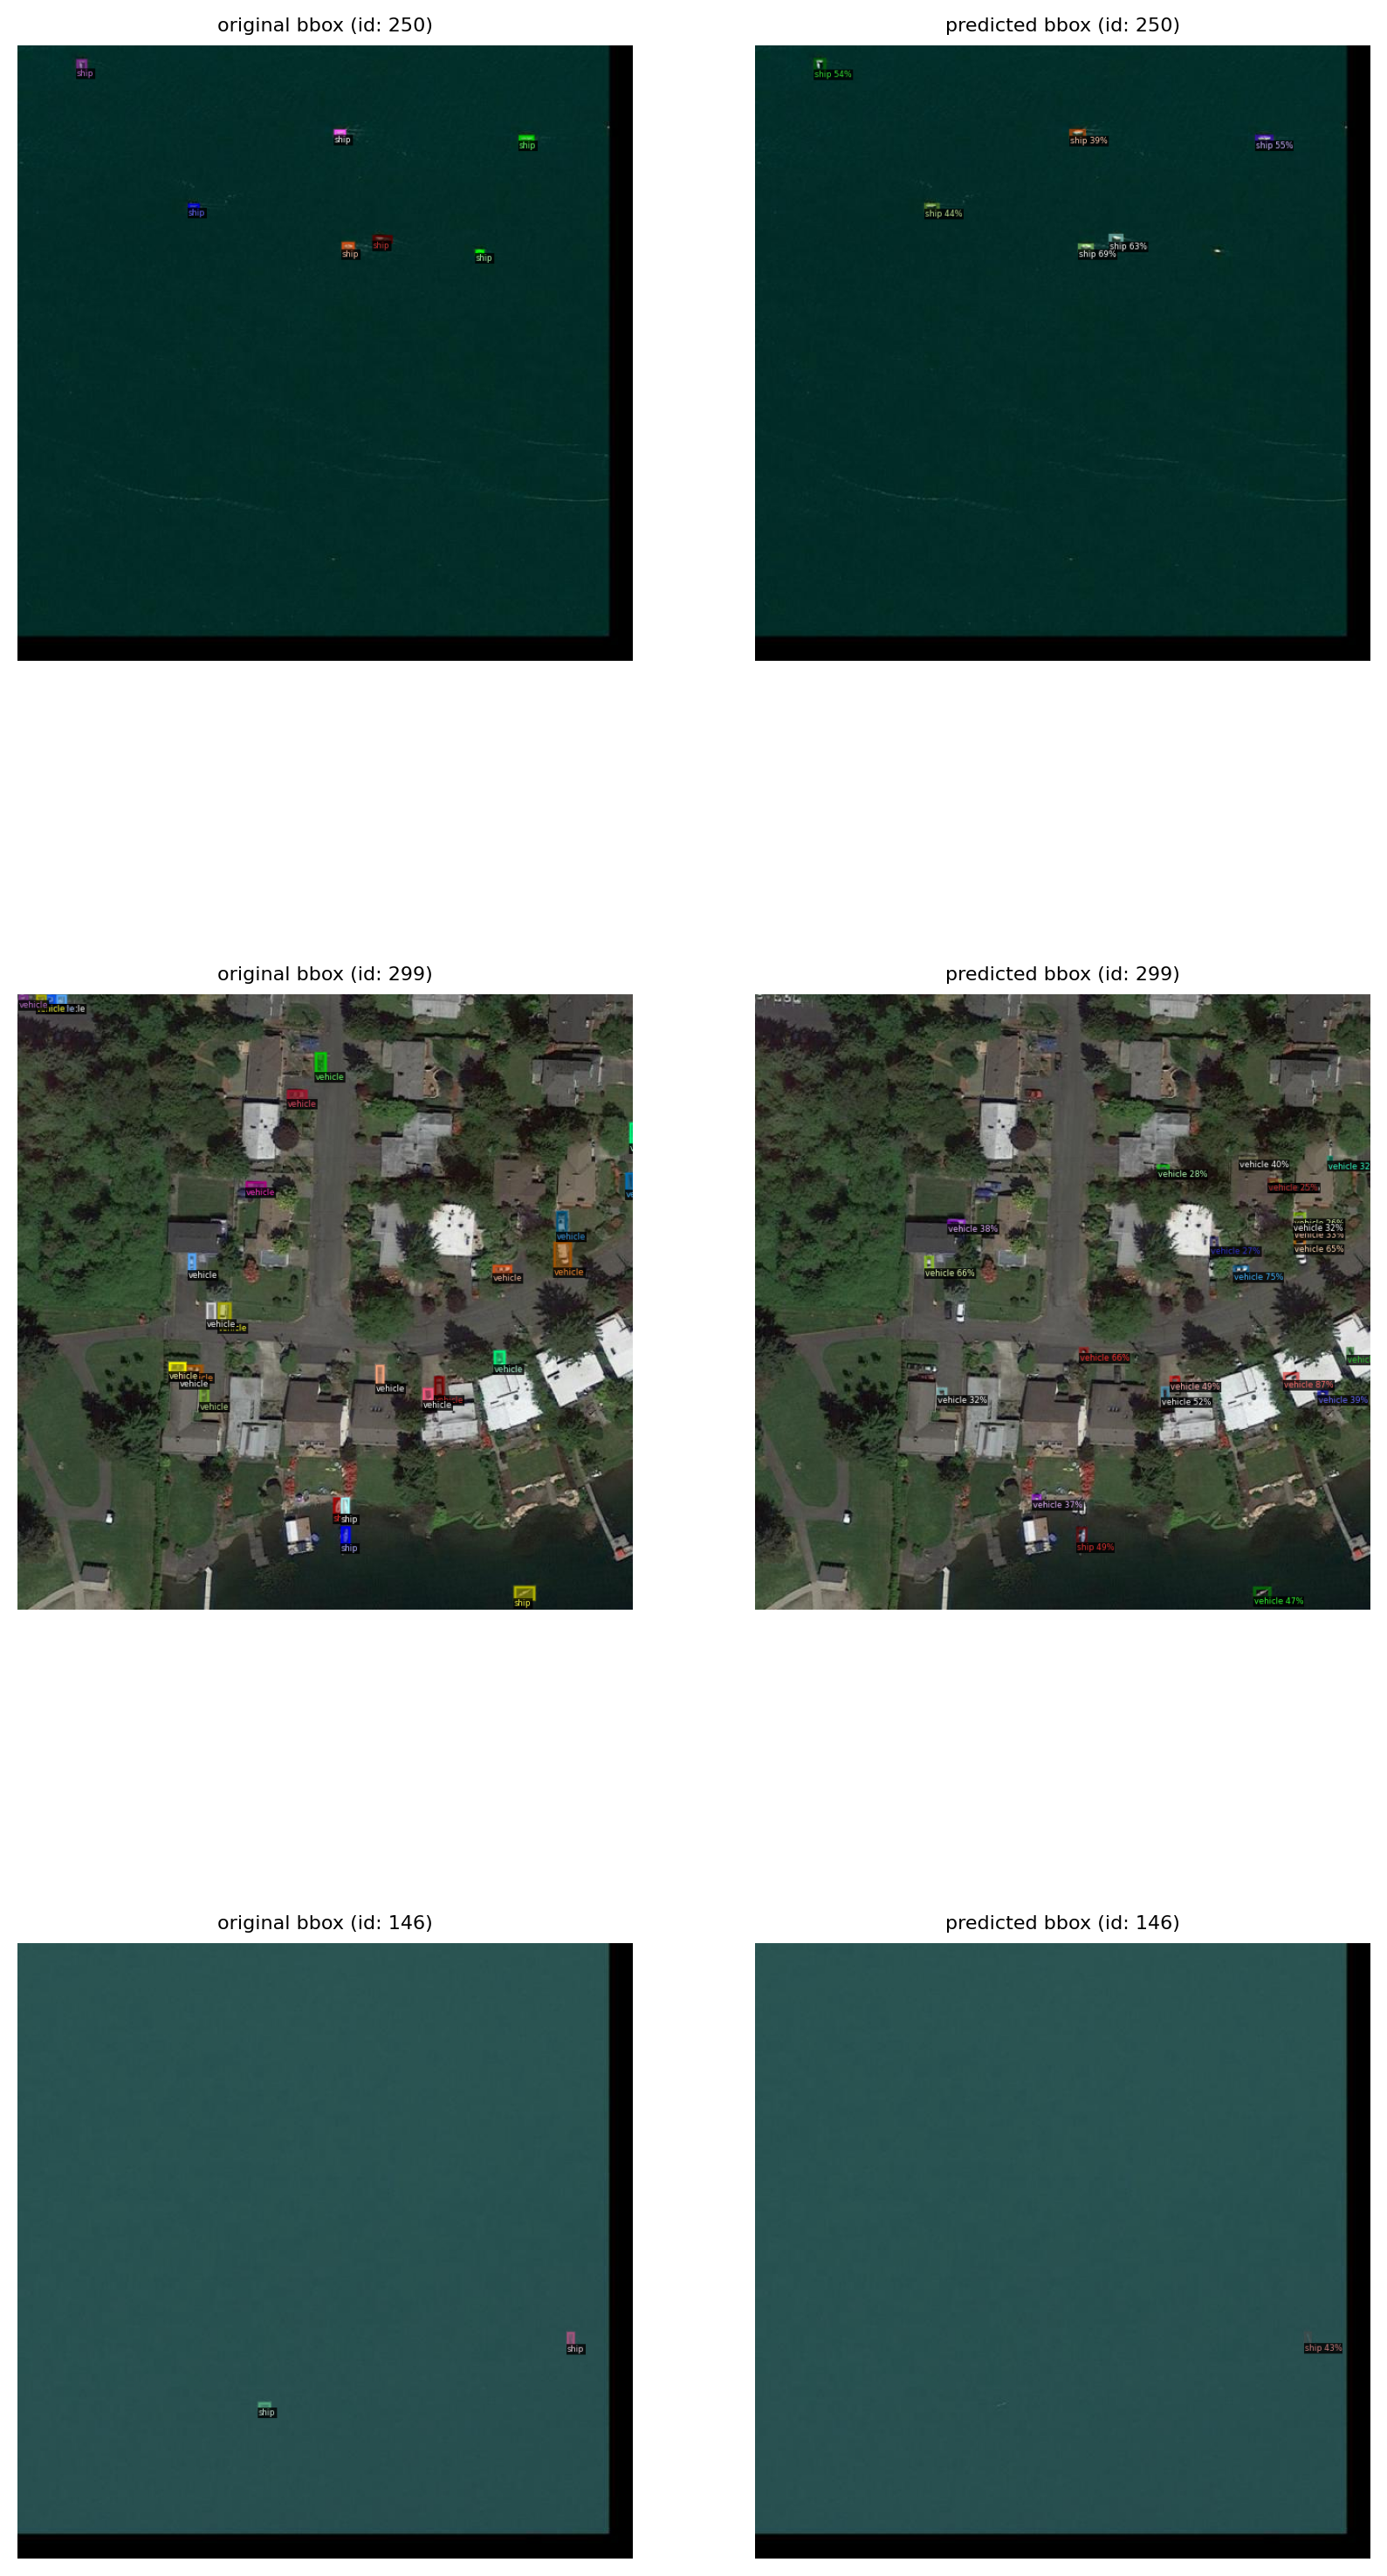

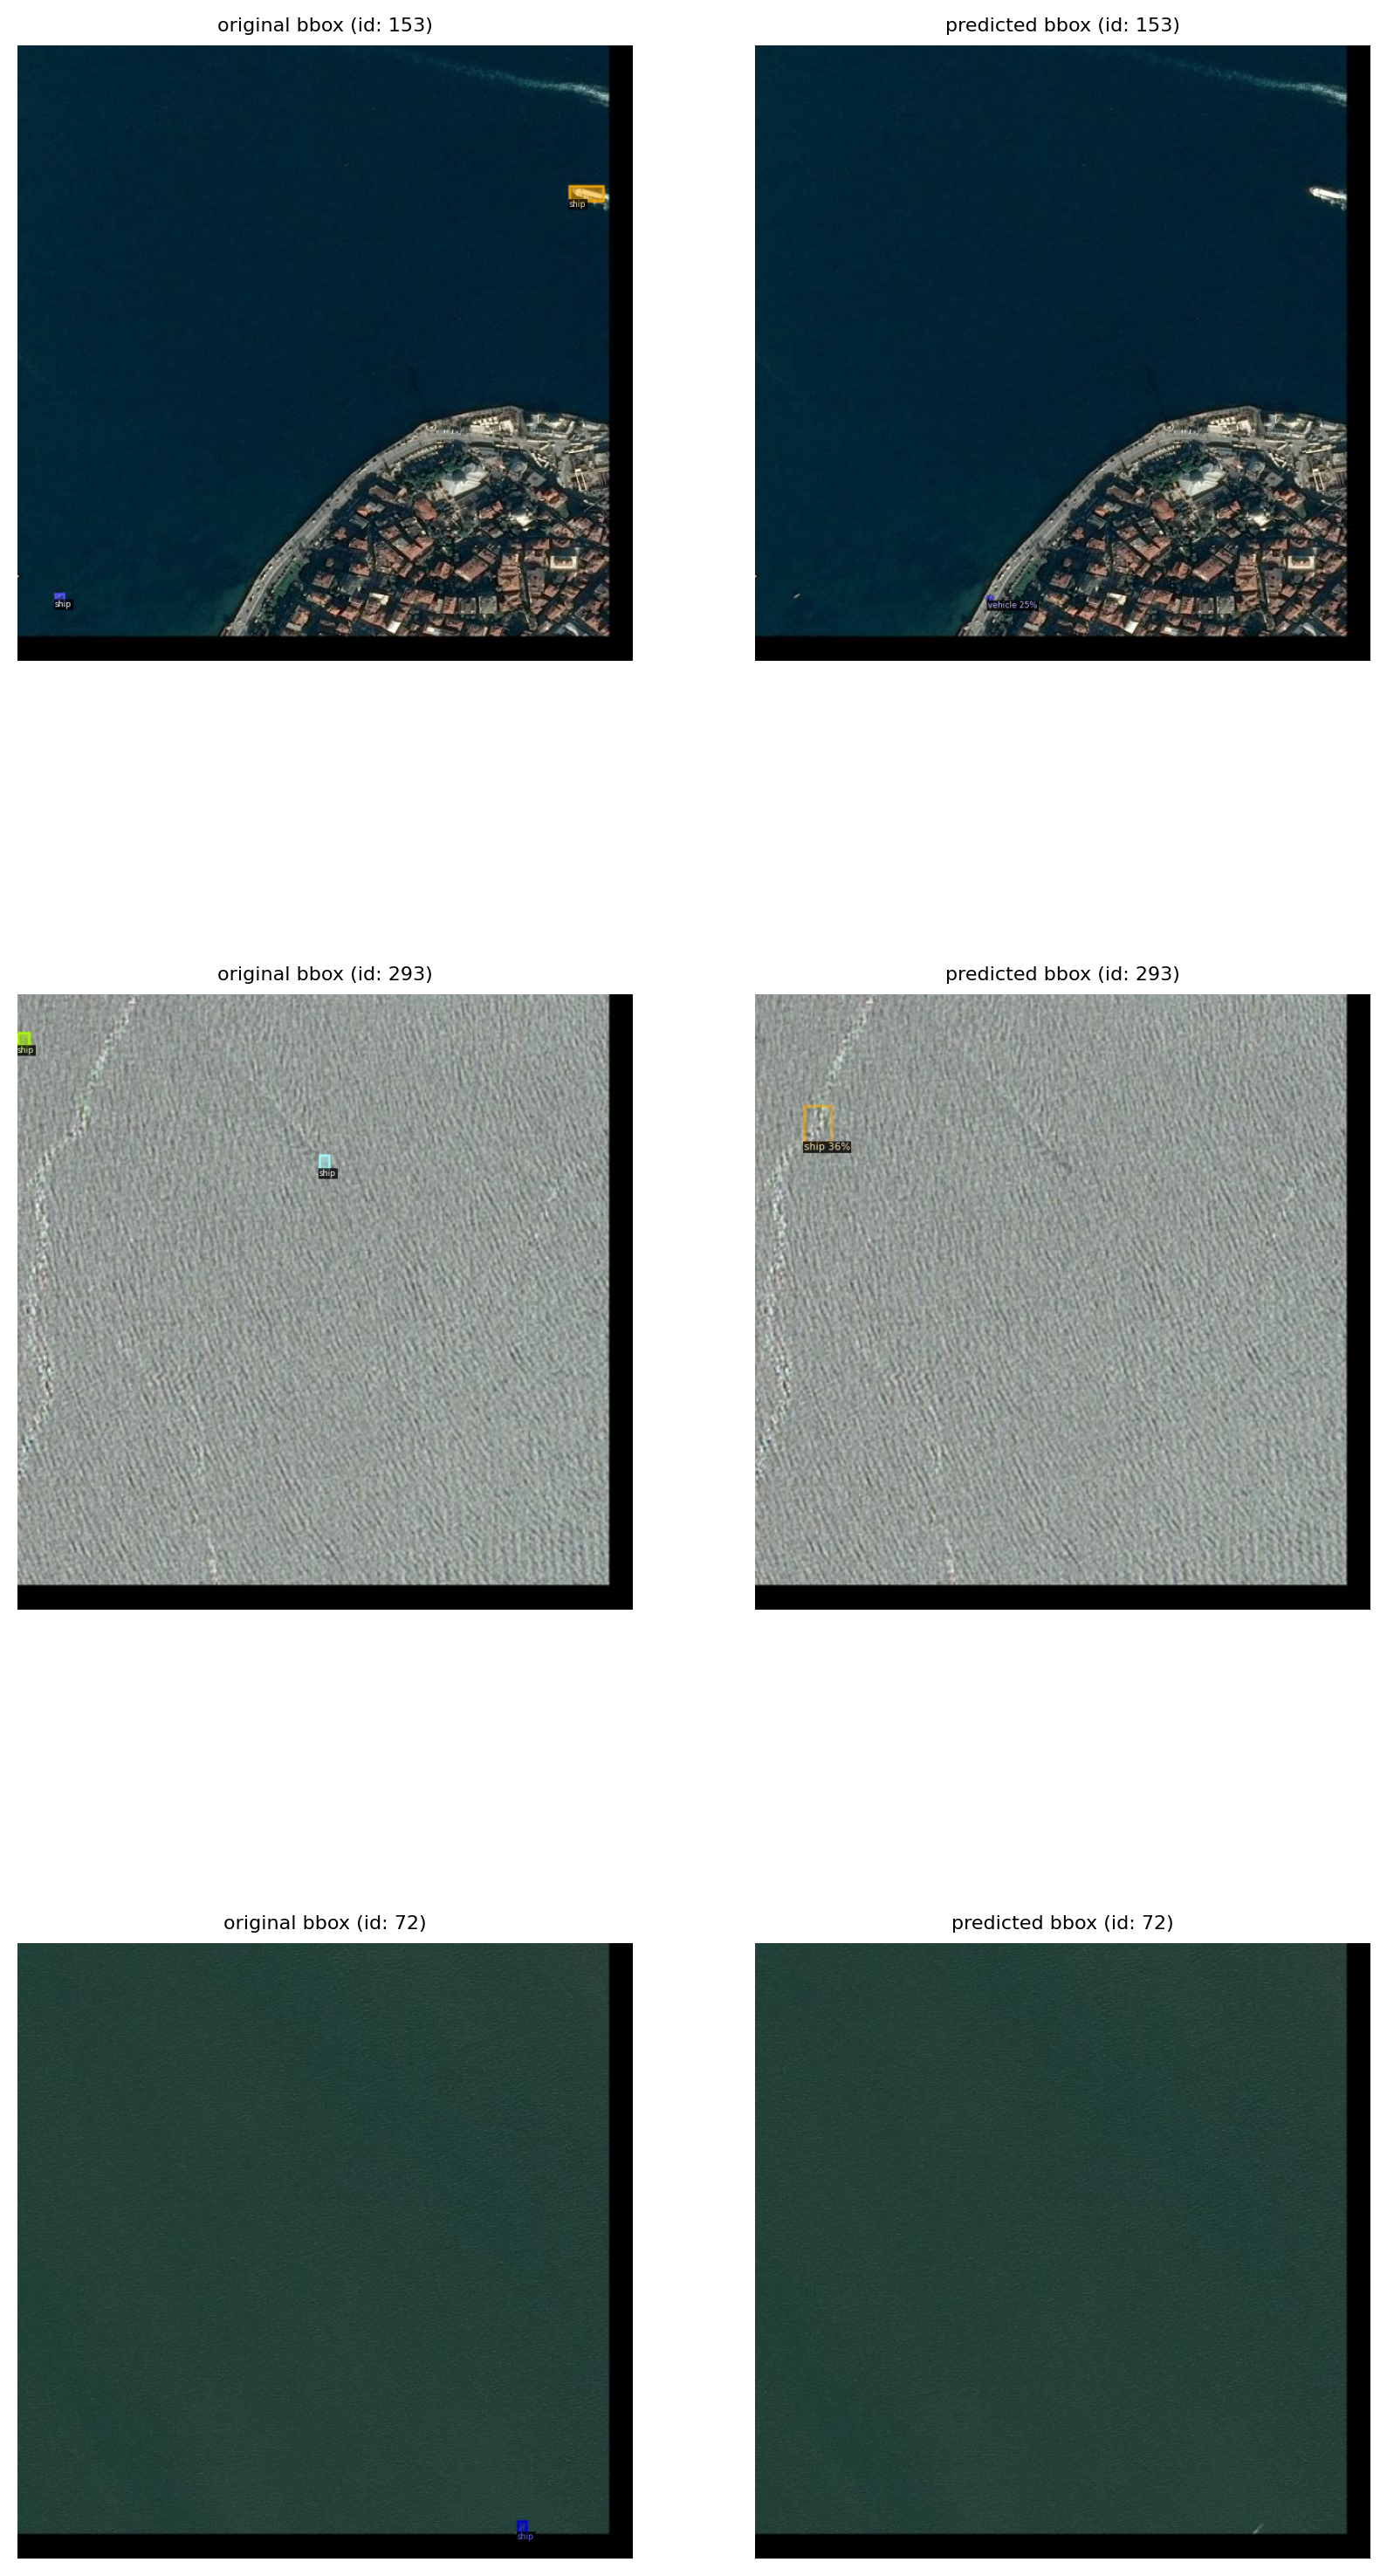

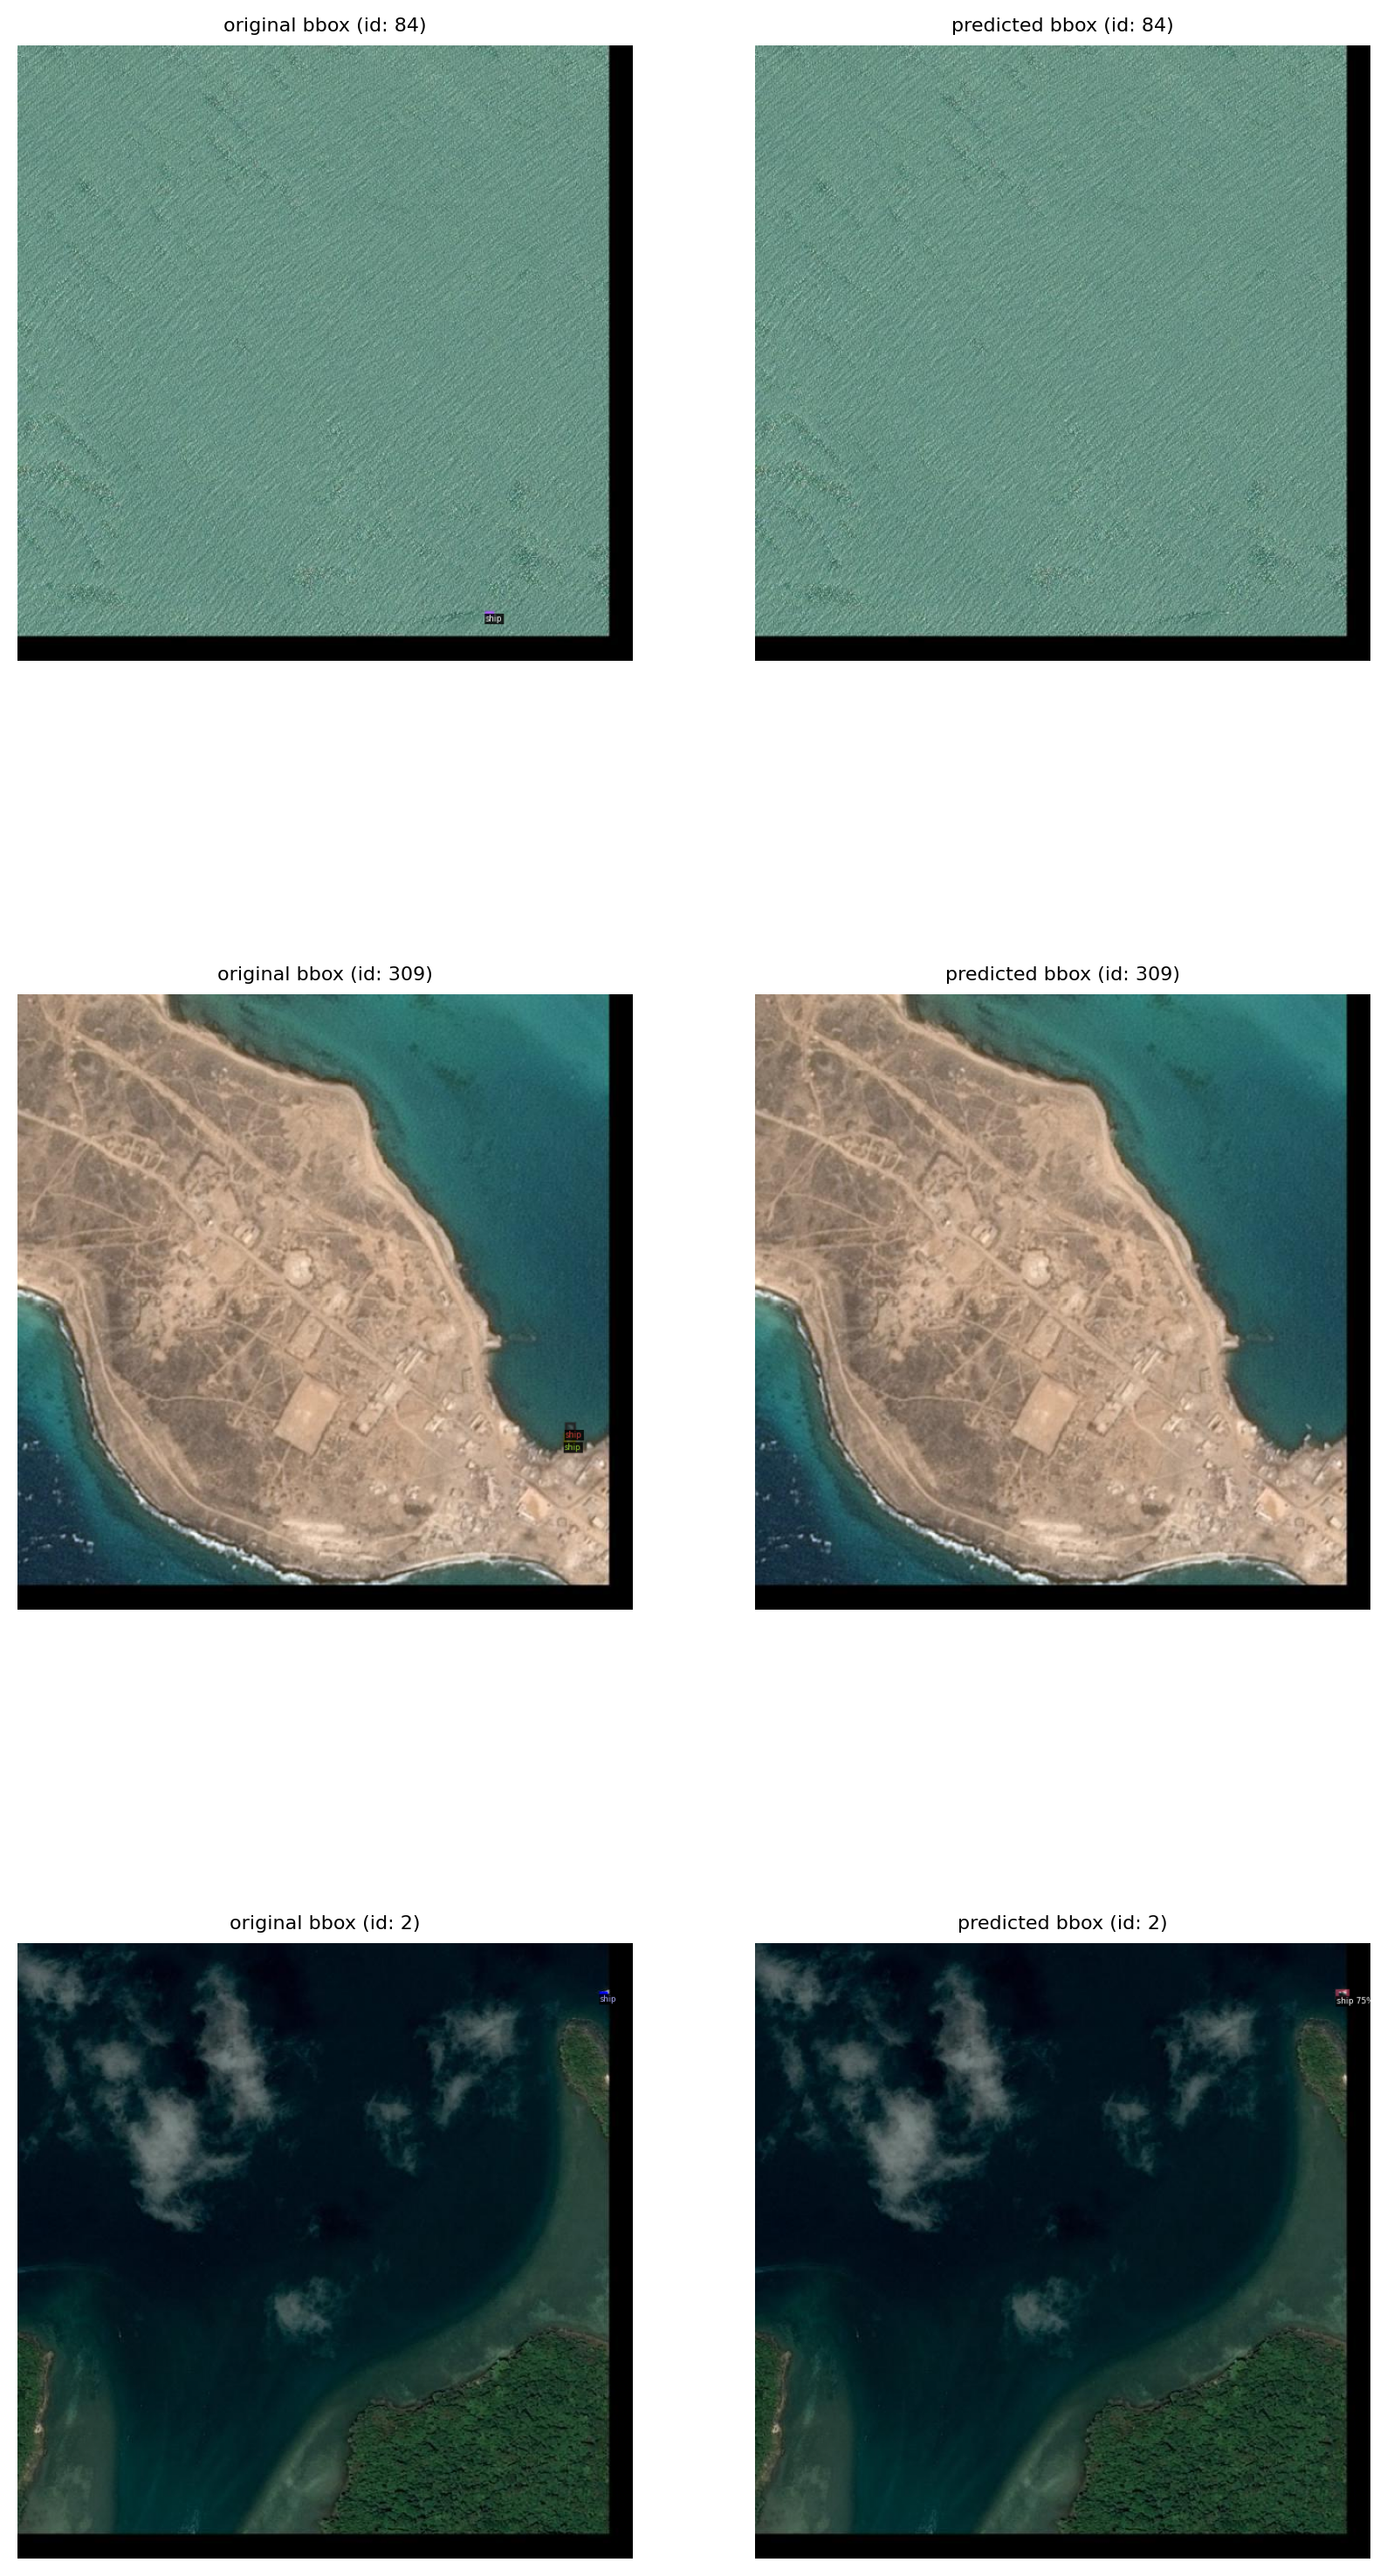

In [11]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 3, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 74, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 65, image_scale=1)